In [1]:
import pandas as pd
import pandasql
import numpy as np
from pandasql import sqldf
import sqlite3
from matplotlib import pyplot as plt
import seaborn as sns
pysqldf = lambda q: sqldf(q, globals())

In [2]:
bom_df = pd.read_csv("data/bom.movie_gross.csv")
tn_df = pd.read_csv("data/tn.movie_budgets.csv")
rt_movies = pd.read_csv("data/rt.movie_info.tsv", delimiter="\t")
rt_reviews = pd.read_csv("data/rt.reviews.tsv", delimiter="\t")
tmdb_df = pd.read_csv("data/tmdb.movies.csv")
tn_df = pd.read_csv("data/tn.movie_budgets.csv")

conn = sqlite3.connect("data/im.db")
imdb_tables = pd.read_sql("""
SELECT name FROM sqlite_master
    WHERE type='table'
""", conn)

movie_basics = pd.read_sql(""" SELECT * FROM movie_basics """, conn)
directors = pd.read_sql(""" SELECT * FROM directors """, conn)
known_for = pd.read_sql(""" SELECT * FROM known_for """, conn)
movie_akas = pd.read_sql(""" SELECT * FROM movie_akas """, conn)
movie_ratings = pd.read_sql(""" SELECT * FROM movie_ratings """, conn)
persons = pd.read_sql(""" SELECT * FROM persons """, conn)
principals = pd.read_sql(""" SELECT * FROM principals """, conn)
writers = pd.read_sql(""" SELECT * FROM writers """, conn)

In [3]:
q = """
SELECT movie_basics.movie_id,
       bom_df.year,
       bom_df.studio,
       bom_df.title,
       movie_basics.runtime_minutes,
       movie_basics.genres,
       tn_df.domestic_gross,
       tn_df.worldwide_gross,
       tn_df.production_budget

FROM tn_df
JOIN bom_df
    ON title = movie
JOIN movie_basics
    ON title = primary_title
"""

df = pysqldf(q)

In [4]:
def money_to_int(x):
    x = x[1:]
    split = x.split(",")
    joined = "".join(split)
    integer = int(joined)
    return integer

In [5]:
# Changing budget and gross columns to integer types
df['production_budget'] = df['production_budget'].map(lambda x: money_to_int(x))
df['domestic_gross'] = df['domestic_gross'].map(lambda x: money_to_int(x))
df['worldwide_gross'] = df['worldwide_gross'].map(lambda x: money_to_int(x))

# Removing null values from genres column and turning them into lowercase
df['genres'] = df['genres'].map(lambda x: 'None' if not x else x)

In [6]:
# Creating new columns
df['foreign_gross'] = df['worldwide_gross'] - df['domestic_gross']
df['ROI'] = round((df['worldwide_gross'] / df['production_budget'])*100, 2)
df['positive_ROI'] = df['ROI'].map(lambda x: True if x>100 else False)

In [7]:
# Removing duplicates (can't be done with pandas .dropduplicates() method)
q = """
SELECT * FROM df
WHERE movie_id NOT IN (SELECT movie_id
                       FROM df
                       GROUP BY movie_id
                       HAVING COUNT(*)>=2)
"""

df = pysqldf(q)

In [8]:
q = """
SELECT person_id, primary_name, category, job, movie_id, year, genres, ROI, positive_ROI
FROM principals
JOIN persons
    USING (person_id)
JOIN df
    USING(movie_id)
WHERE movie_id IN (SELECT movie_id FROM df)
"""

cast = pysqldf(q)

In [9]:
genres = (list(cast['genres'].unique()))
genres.remove('None')
genres = ",".join(genres)
genres = genres.split(",")
genres = sorted(list(set(genres)))

In [10]:
for i in genres:
    cast["is_"+i] = cast['genres'].map(lambda x: True if i in x else False)

In [11]:
professions = list(cast['category'].unique())
professions

['cinematographer',
 'actor',
 'director',
 'producer',
 'composer',
 'actress',
 'writer',
 'editor',
 'production_designer',
 'self',
 'archive_footage',
 'archive_sound']

# Our primary dataset

The dataframe we just created, **cast**, is the dataset from which we will pull all other data from.

From the list of professions above, we will only focus on actors, directors, producers, actresses, and writers. All the others are not as important. The list is updated below.

In [12]:
professions = ['actor', 'actress', 'director', 'producer', 'writer']

In [13]:
cast.head()

,person_id,primary_name,category,job,movie_id,year,genres,ROI,positive_ROI,is_Action,...,is_Music,is_Musical,is_Mystery,is_News,is_Romance,is_Sci-Fi,is_Sport,is_Thriller,is_War,is_Western
0,nm0005683,Roger Deakins,cinematographer,director of photography,tt0475290,2016,"Comedy,Drama,Music",291.64,1,False,...,True,False,False,False,False,False,False,False,False,False
1,nm0000982,Josh Brolin,actor,None,tt0475290,2016,"Comedy,Drama,Music",291.64,1,False,...,True,False,False,False,False,False,False,False,False,False
2,nm0000123,George Clooney,actor,None,tt0475290,2016,"Comedy,Drama,Music",291.64,1,False,...,True,False,False,False,False,False,False,False,False,False
3,nm2403277,Alden Ehrenreich,actor,None,tt0475290,2016,"Comedy,Drama,Music",291.64,1,False,...,True,False,False,False,False,False,False,False,False,False
4,nm0000146,Ralph Fiennes,actor,None,tt0475290,2016,"Comedy,Drama,Music",291.64,1,False,...,True,False,False,False,False,False,False,False,False,False


# Desired data

Each person's hitrate.\
Each person's average ROI\
Each person's number of movies\
Each person's genres

In [14]:
q = """
SELECT person_id,
       primary_name,
       category,
       AVG(ROI) as average_ROI, 
       AVG(positive_ROI) as hitrate,
       COUNT(*) as num_movies,
       GROUP_CONCAT(genres) as genres
       
FROM cast

GROUP BY person_id
""" 

cast_stats = pysqldf(q)

In [15]:
cast_stats.head()

,person_id,primary_name,category,average_ROI,hitrate,num_movies,genres
0,nm0000084,Li Gong,actress,31.010000,0.000000,1,"Crime,Drama,Mystery"
1,nm0000092,John Cleese,actor,203.463333,0.666667,3,"Adventure,Animation,Comedy,Comedy,Action,Adven..."
2,nm0000093,Brad Pitt,actor,276.669091,0.909091,11,"Action,Animation,Comedy,Crime,Thriller,Action,..."
3,nm0000095,Woody Allen,director,421.860000,1.000000,4,"Comedy,Fantasy,Romance,Comedy,Drama,Romance,Co..."
4,nm0000098,Jennifer Aniston,actress,298.872857,0.857143,7,"Action,Comedy,Romance,Comedy,Romance,Comedy,Dr..."


In [16]:
cast_stats.genres = cast_stats.genres.map(lambda x: \
                                          ','.join(sorted(list(set(x.split(','))))))

In [17]:
cast_stats.head()

,person_id,primary_name,category,average_ROI,hitrate,num_movies,genres
0,nm0000084,Li Gong,actress,31.010000,0.000000,1,"Crime,Drama,Mystery"
1,nm0000092,John Cleese,actor,203.463333,0.666667,3,"Action,Adventure,Animation,Comedy"
2,nm0000093,Brad Pitt,actor,276.669091,0.909091,11,"Action,Adventure,Animation,Biography,Comedy,Cr..."
3,nm0000095,Woody Allen,director,421.860000,1.000000,4,"Comedy,Drama,Fantasy,Music,Romance"
4,nm0000098,Jennifer Aniston,actress,298.872857,0.857143,7,"Action,Adventure,Animation,Comedy,Crime,Drama,..."


# Profession questions

What is each profession's hitrate?
What is each profession's ROI?

In [18]:
professions

['actor', 'actress', 'director', 'producer', 'writer']

In [19]:
actor_stats = cast_stats[cast_stats.category=='actor']
actress_stats = cast_stats[cast_stats.category=='actress']
director_stats = cast_stats[cast_stats.category=='director']
producer_stats = cast_stats[cast_stats.category=='producer']
writer_stats = cast_stats[cast_stats.category=='writer']

stats_dfs = [actor_stats, actress_stats, director_stats, producer_stats, writer_stats]

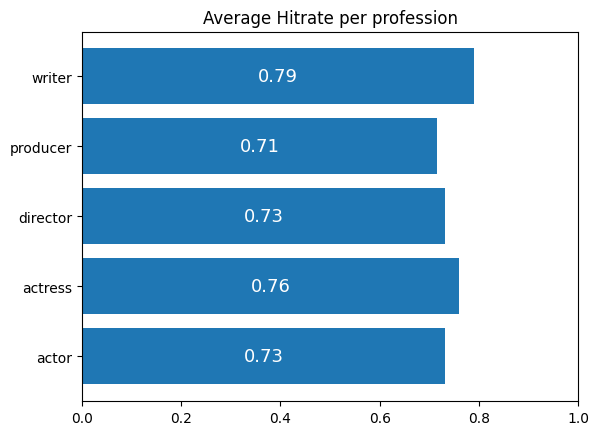

In [20]:
fig, ax = plt.subplots()

title = 'Average Hitrate per profession'

x = professions
y = [i.hitrate.mean() for i in stats_dfs]

ylabels=[round(i,2) for i in y]

ax.set_title(title)

ax.set_xlim(0, 1)

barplot = ax.barh(x,y)
ax.bar_label(barplot, labels=ylabels, label_type='center', color='white', fontsize='13');

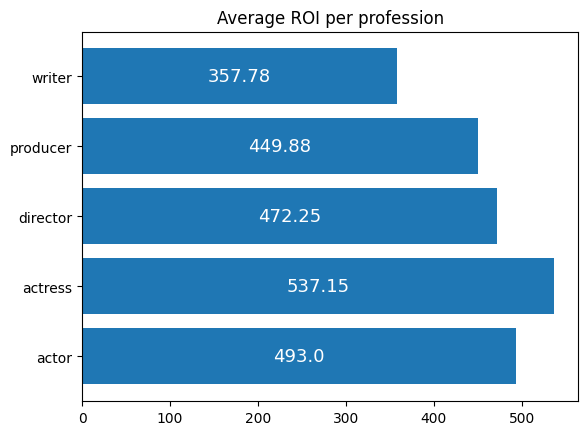

In [21]:
fig, ax = plt.subplots()

title = 'Average ROI per profession'

x = professions
y = [i.average_ROI.mean() for i in stats_dfs]

ylabels=[round(i,2) for i in y]

ax.set_title(title)

barplot = ax.barh(x,y)
ax.bar_label(barplot, labels=ylabels, label_type='center', color='white', fontsize='13');

# Predictive Questions

What is the predictive power of a profession's average ROI on whether movie hitrates?\
What is the predictive power of a profession's average ROI on a movie's ROI?\
What is the predictive power of a profession's hitrate on whether movie hitrates?\
What is the predictive power of a profession's hitrate on a movie's ROI?\

Does hiring successful, reliable people lead to the highest ROI/hitrate?

Of all these people, which profession has the highest predictive power?

Of all the questions we've asked so far, these are perhaps the most important. In order to use a person's stats to PREDICT a movie's success, we wil need to divide our dataset into two across a particular year. Each person's success in the first dataset will be used to predict a movie's success in the second.

The first step is to decide which year to split down on. Ideally, you would like two datasets with a similar number of people in it. First, let's see what years we have to work with.

In [22]:
years = sorted(cast.year.unique())

We have 9 years to work with. Thankfully, there are no missing years from this dataset.

When you split down a year, you want as many people in common between the two datasets as possible. Even if you have 5000 people in one and 5000 people in the other, what good does that do if none of the people from the first are in the second?

We need to maximize the number of people in common between the two datasets.

In [23]:
for i in sorted(cast.year.unique()):
    persons_set_1 = set(cast[cast.year<=i].person_id.unique())
    persons_set_2 = set(cast[cast.year>i].person_id.unique())
                        
    print(
        str(i) + ": ",
        len((persons_set_1).intersection(persons_set_2))
    )

2010:  688
2011:  1153
2012:  1381
2013:  1440
2014:  1400
2015:  1221
2016:  869
2017:  471
2018:  0


2013 maximizes the number of unique people shared between the datasets. Therefore, we will split down 2013.

In [24]:
year = 2013

dataset1 = cast[cast.year <= year].copy()
dataset2 = cast[cast.year > year].copy()

We now how to update these datasets to include only the people they both have.

In [25]:
intersection = set(dataset1.person_id.unique()).intersection(set(dataset2.person_id.unique()))
len(intersection)

1440

In [26]:
dataset1 = dataset1[dataset1.person_id.isin(intersection)]
dataset2 = dataset2[dataset2.person_id.isin(intersection)]

# Using the datasets to tackle predictive questions

What is the predictive power of a profession's ROI on whether a movie is successful?

Let's take a specific profession (actor) as an example. We would first find the average ROI of every actor in the first dataset. We would then determine the range of average ROI's in that set of actors (let's say it ranges from 30% to 500%). We would then divide those actors into different groups – actors with up to 100% average ROI, between 100% and 200% average ROI, between 200% and 300%, etc. We would then find the average ROI of movies with those actors in the second dataset, and see if that ROI goes up with actor ROI.

# Are the values in our dataset wildly different?

If so, any comparisons we make between the two might not be meaningful.

In [27]:
attributes = ('ROI', 'positive_ROI')

for a in attributes:
    for i in professions:
        mean1 = dataset1[dataset1.category==i][a].mean()
        mean2 = dataset2[dataset2.category==i][a].mean()
        print("{} average {}: {}, {}".format(i, a, mean1, mean2))
    
    print("\n")

actor average ROI: 332.4529312288613, 348.6424282296651
actress average ROI: 394.7332062780269, 410.05195804195813
director average ROI: 476.026632996633, 434.87605769230765
producer average ROI: 441.0895527728086, 601.9884579439251
writer average ROI: 460.14073232323227, 391.79586633663365


actor average positive_ROI: 0.7936865839909808, 0.8026315789473685
actress average positive_ROI: 0.8071748878923767, 0.8298368298368298
director average positive_ROI: 0.8855218855218855, 0.842948717948718
producer average positive_ROI: 0.815742397137746, 0.8255451713395638
writer average positive_ROI: 0.9015151515151515, 0.8861386138613861




It looks like the values aren't wildy different for either dataset; thankfully, they remain mostly similar. There is one exception: the average ROI of producers went up from 441% to 601% between the first and second time period. Any conclusions we take from producer ROI might have to be taken with a little grain of salt.

We can begin to answer our first question: "What is the predictive power of a profession's ROI on whether a movie is successful?" We will begin with the actors.

Now we have to divide this range into bins. Let's go for 20 bins with a range of 0-1000.

In [97]:
def query(category, profession_attribute, movie_attribute):
    dataset3 = dataset2
    linspace = None
    
    if profession_attribute == "ROI":
        linspace = np.linspace(0,1000,21, dtype=int)
    elif profession_attribute == "positive_ROI":
        linspace = np.linspace(0,1.01,20)
    else:
        return "Invalid profession attribute"
    
    ROIs = []
    ranges=[]

    for i in range(len(linspace)-1):

        q = """
        SELECT person_id
        FROM dataset1
        GROUP BY person_id
        HAVING category == '{}' AND AVG({})>{} AND AVG({})<{}

        """.format(category, profession_attribute, linspace[i], profession_attribute, linspace[i+1])

        range_df = pysqldf(q)
        
        if len(range_df)<5:
            continue

        q2 = """
        SELECT *
        FROM dataset3
        WHERE person_id IN (SELECT person_id FROM range_df)
        """

        range2_df = sqldf(q2, locals())

        ROIs.append(range2_df[movie_attribute].mean())
        
        start = round(linspace[i], 2)
        end = round(linspace[i+1], 2)
        ranges.append('{} – {}, [{} values]'.format(start, end, len(range_df)))
        
    correlation = np.corrcoef(range(0,len(ROIs)),ROIs)[0,1]    
    return ranges, ROIs, correlation

In [98]:
def plot(title, x, y):
    
    fig, ax = plt.subplots(figsize=(15,5))

    ax.set_title(title, fontsize='20')


    ax.scatter(x, y)
    
    if max(y)>1:
        ax.set_ylim(0, 1000)
    else:
        ax.set_ylim(0,1)


    plt.xticks(
        rotation=65,
        horizontalalignment = 'right'
    )

    # Code comes from https://www.python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib
    b, a = np.polyfit(range(0,len(y)), y, deg=1)
    xseq = np.linspace(0, len(y), num=100)
    ax.plot(xseq, a + b * xseq, color="k", lw=2.5);

    # Correlation line comes from https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy
    correlation = np.corrcoef(range(0,len(y)),y)[0,1]

    ax.text(.01,
             .99, 
             "r = {}".format(str(correlation)),
             ha='left',
             va='top',
             transform=ax.transAxes,
             fontsize = 15);

Now we're ready to put both of our functions to good use.

In [30]:
# linspace = np.linspace(0,1000,21, dtype=int)
# linspace

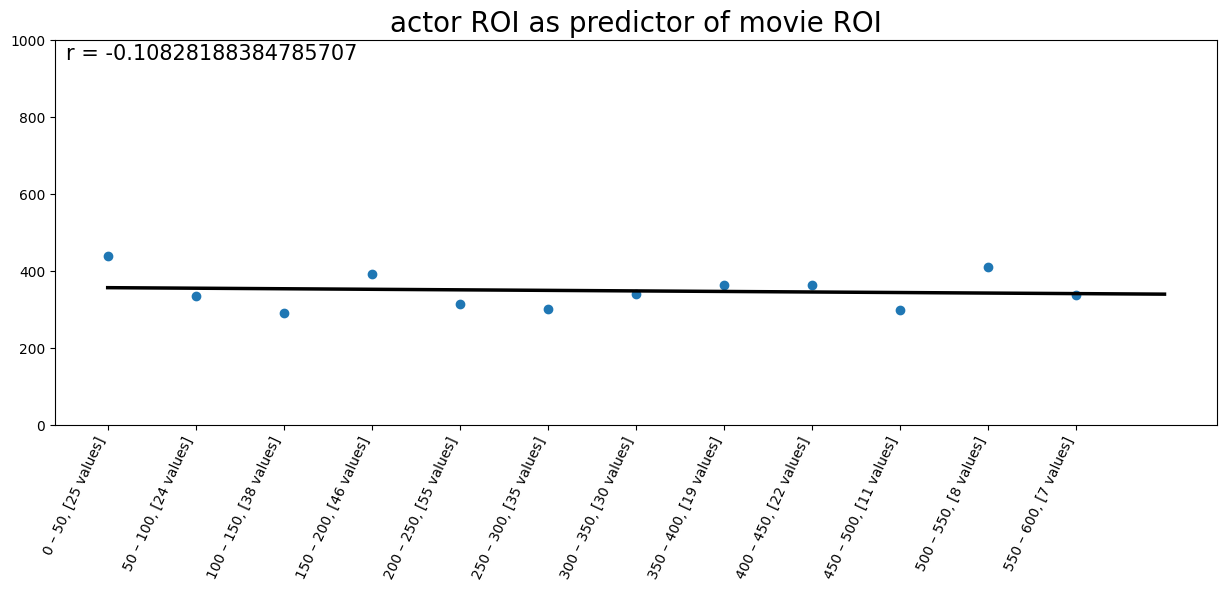

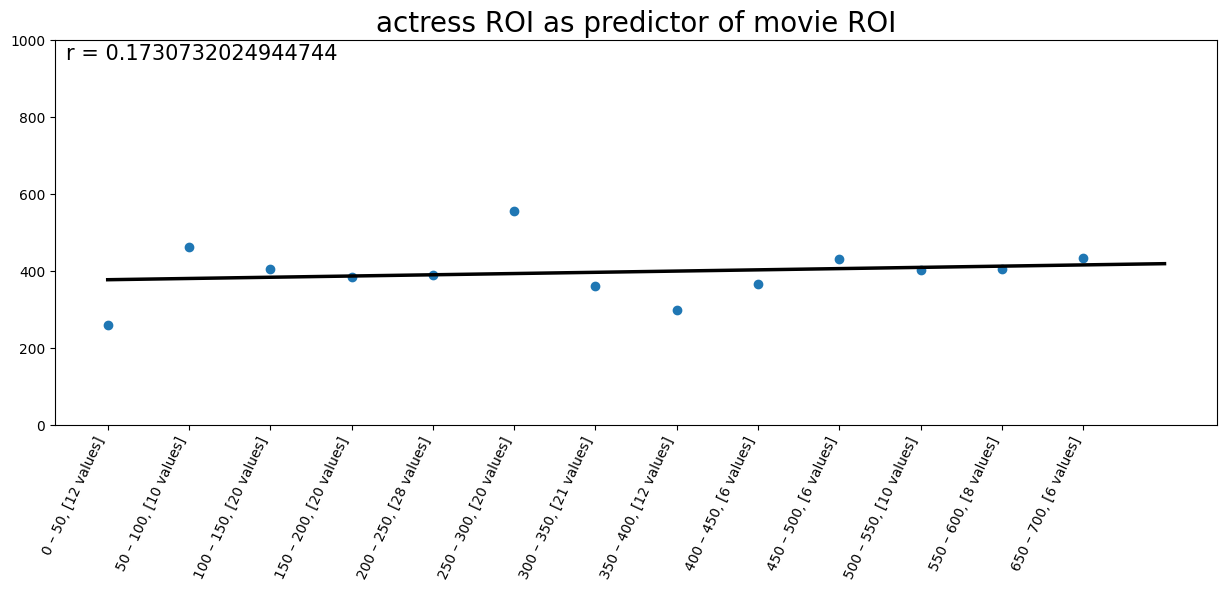

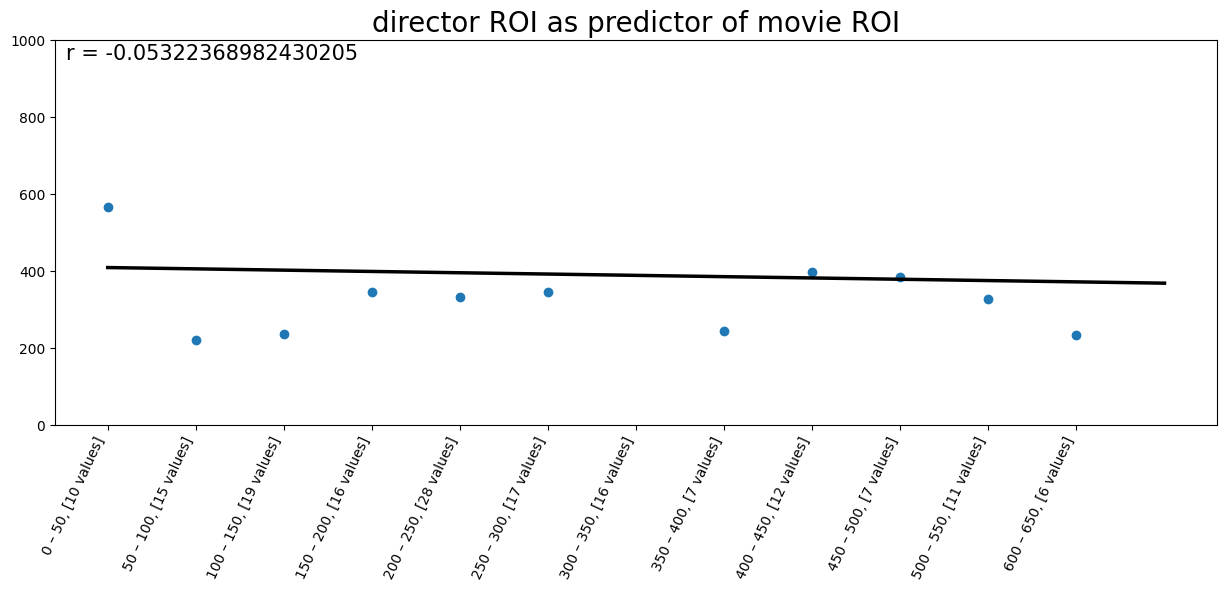

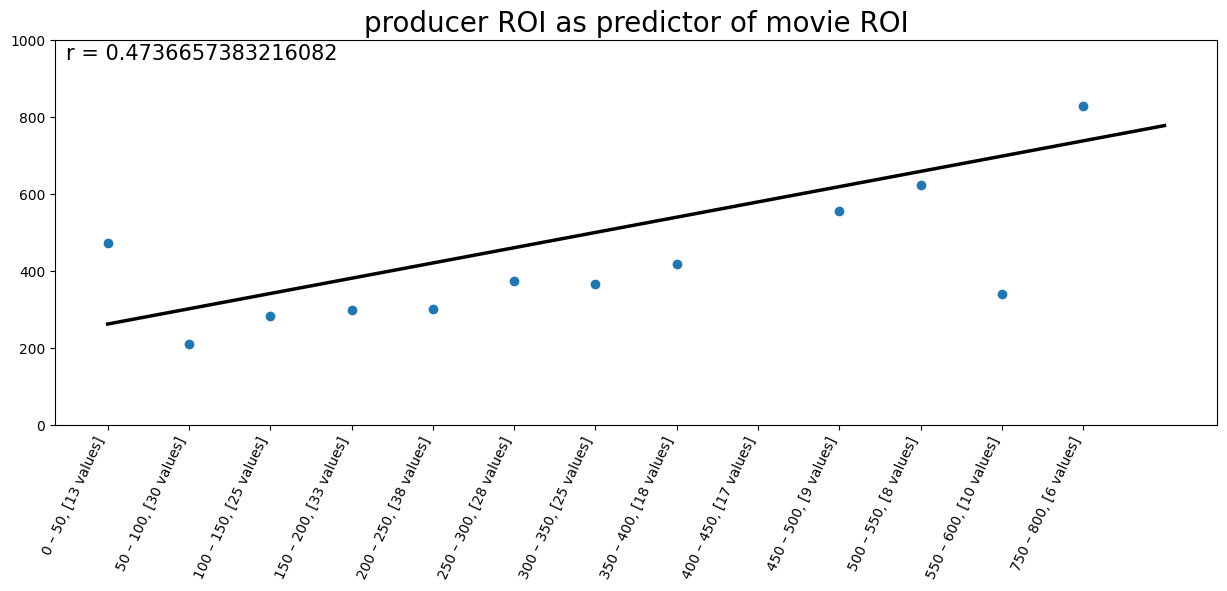

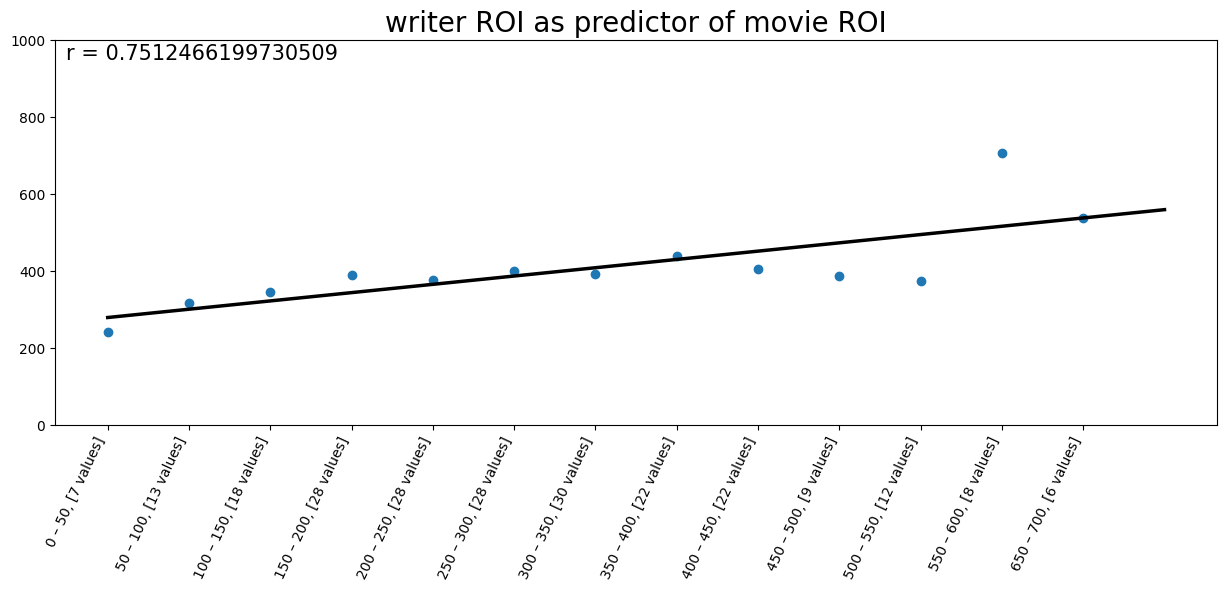

In [31]:
for profession in professions:
    plot(
        "{} ROI as predictor of movie ROI".format(profession),
        query(profession, 'ROI', 'ROI')[0],
        query(profession, 'ROI', 'ROI')[1],
    )

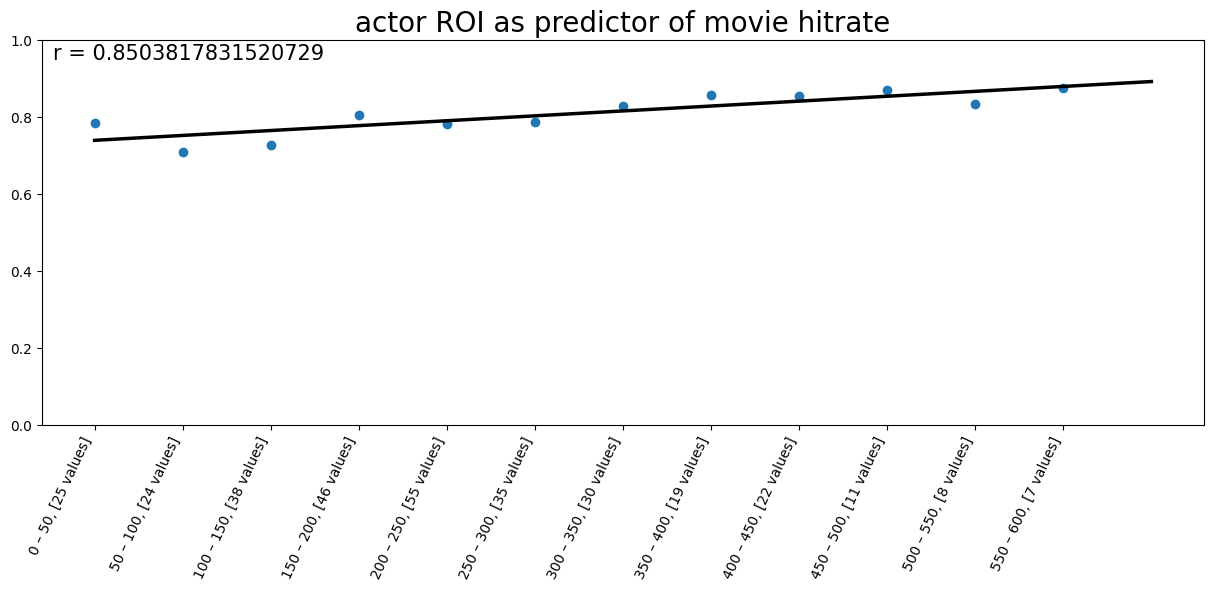

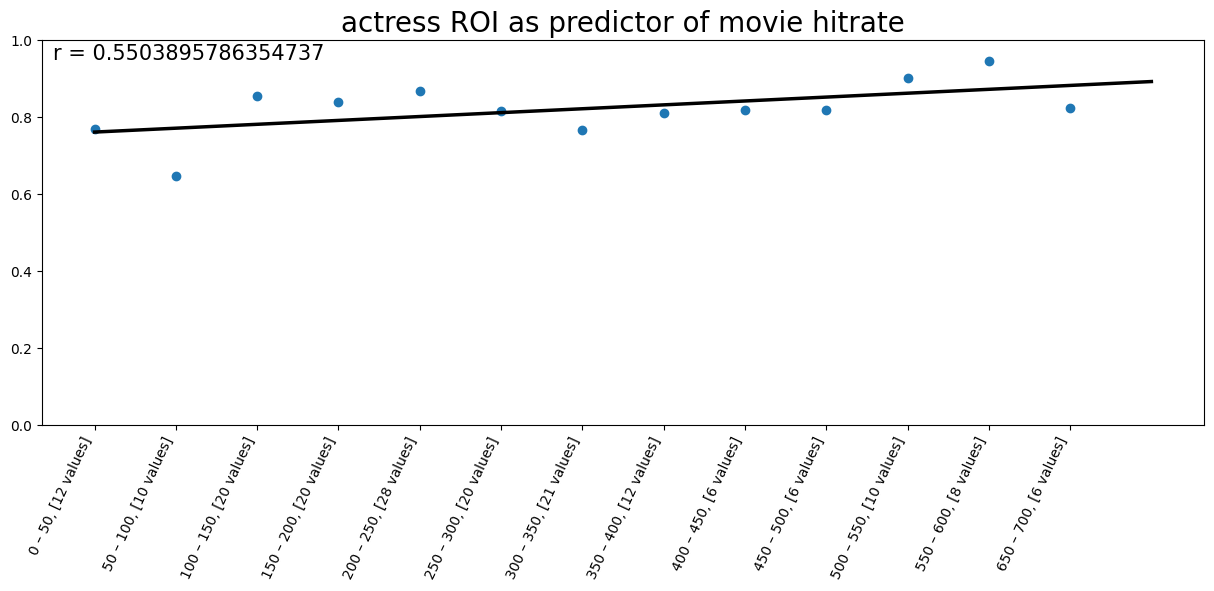

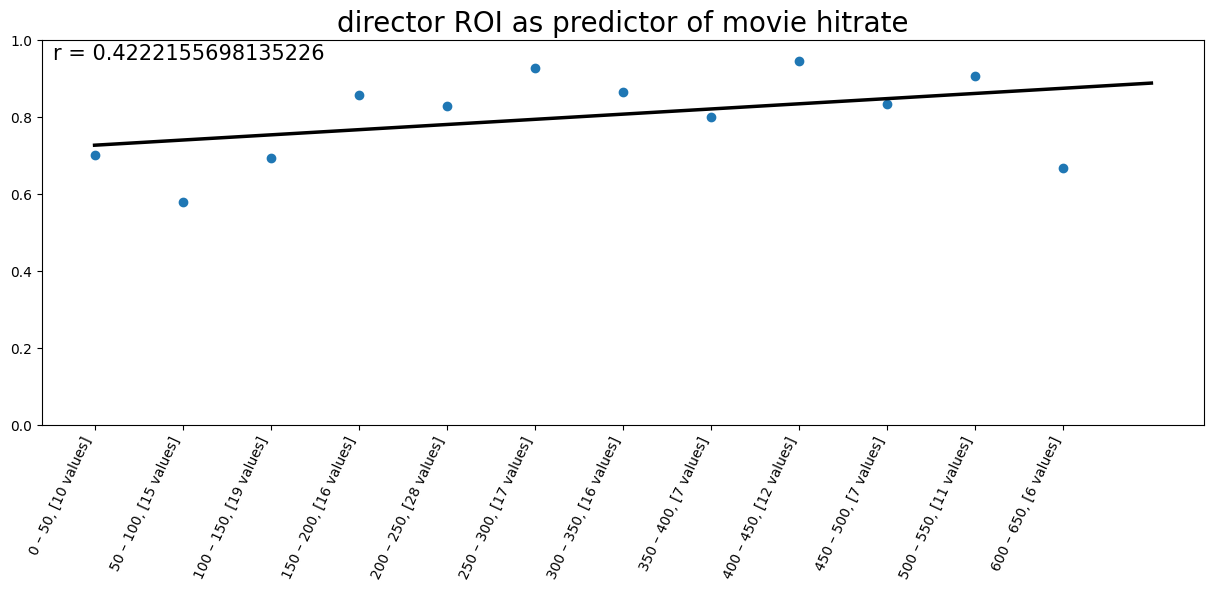

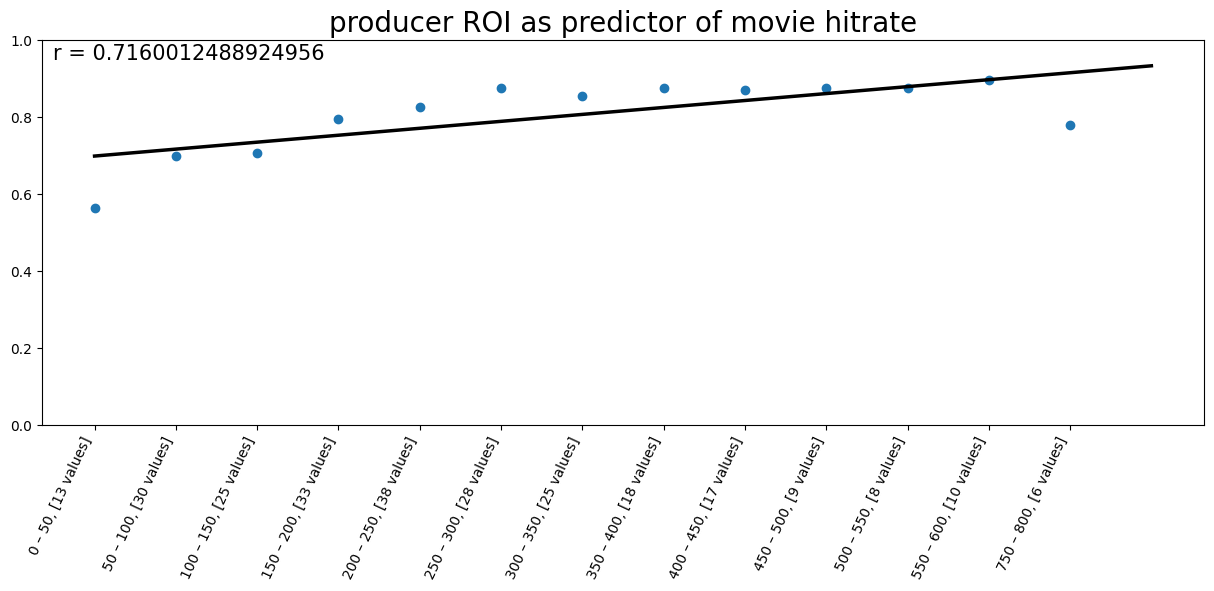

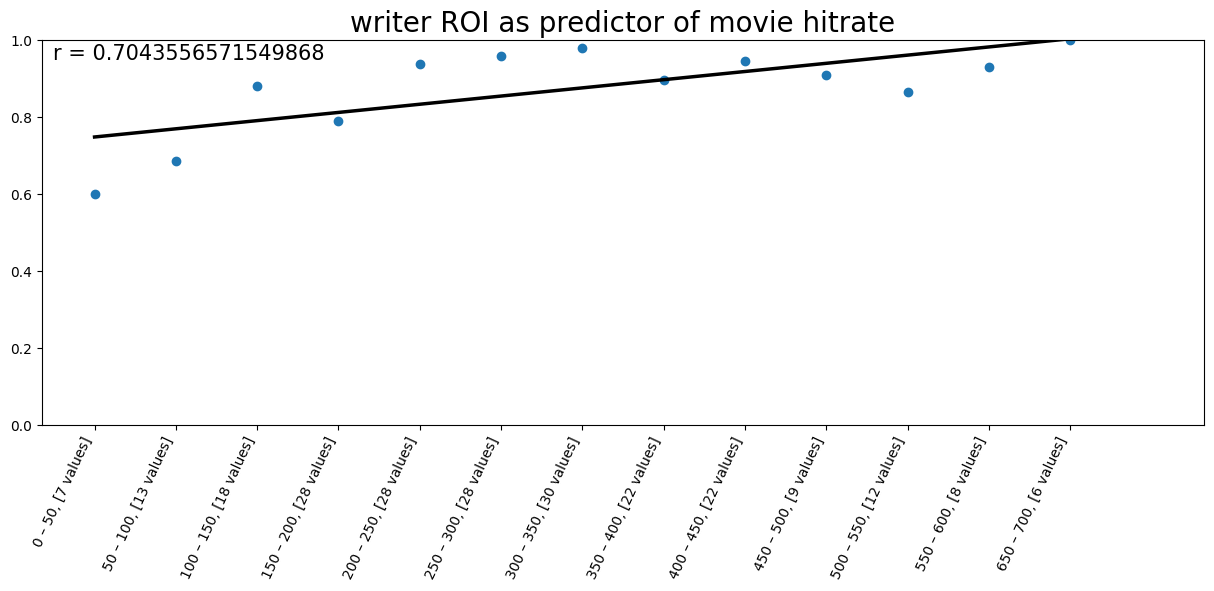

In [32]:
for profession in professions:
    plot(
        "{} ROI as predictor of movie hitrate".format(profession),
        query(profession, 'ROI', 'positive_ROI')[0],
        query(profession, 'ROI', 'positive_ROI')[1],
    )

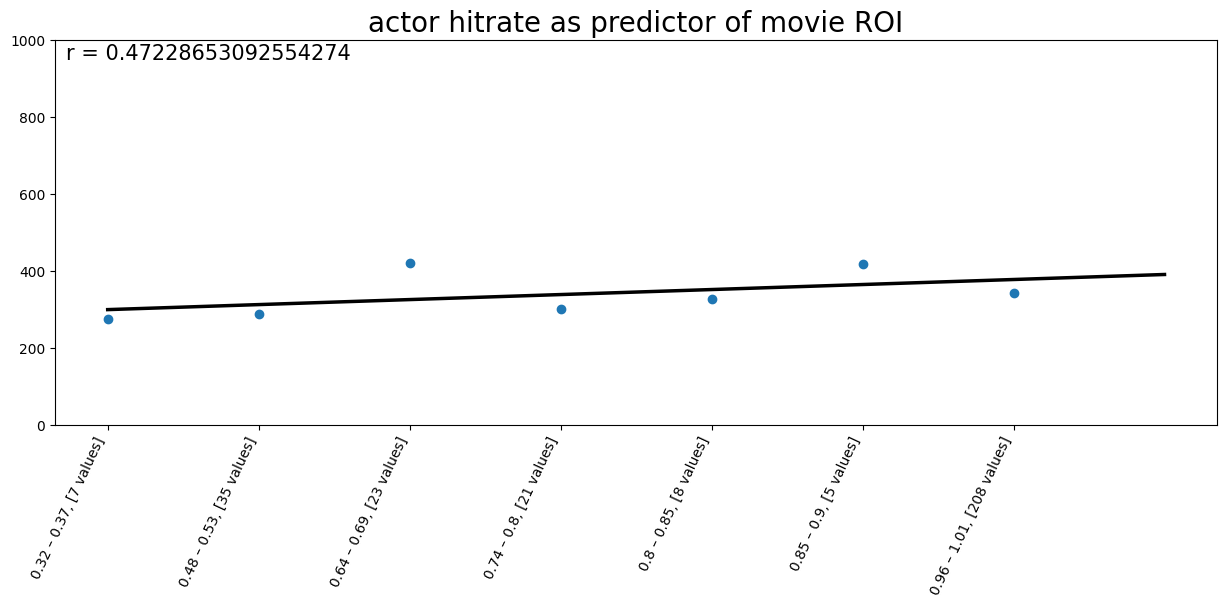

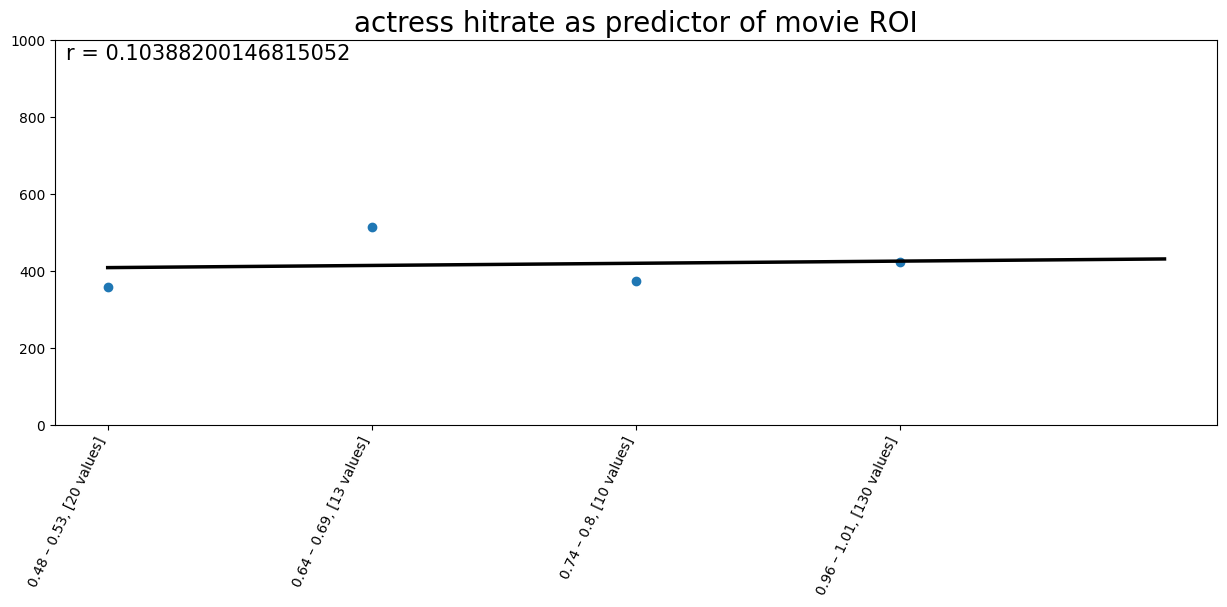

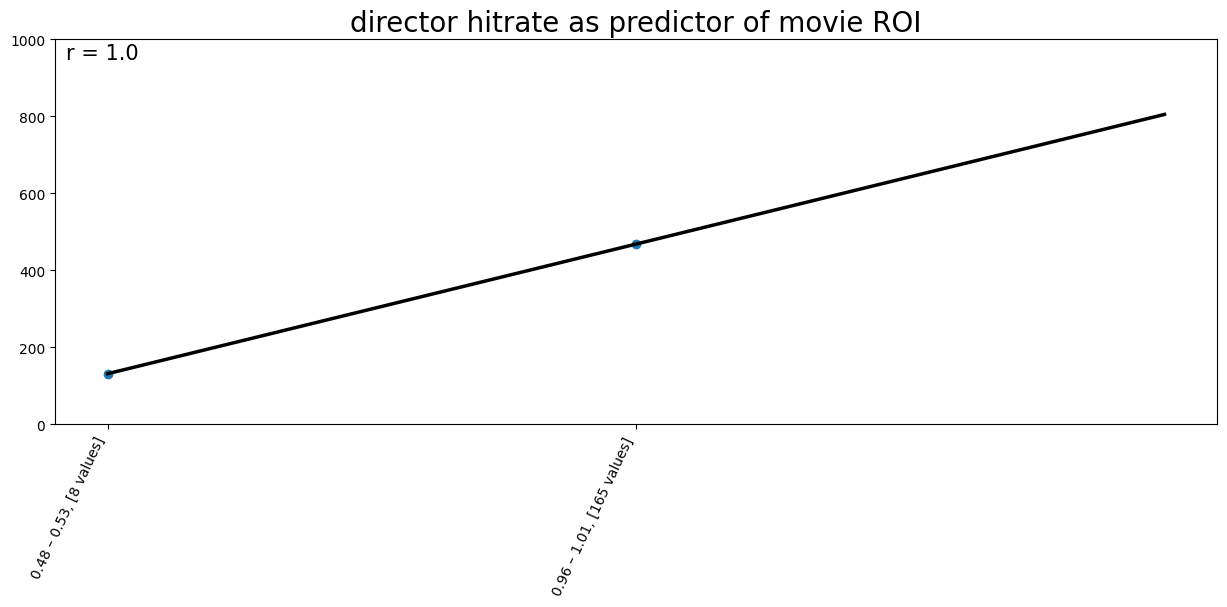

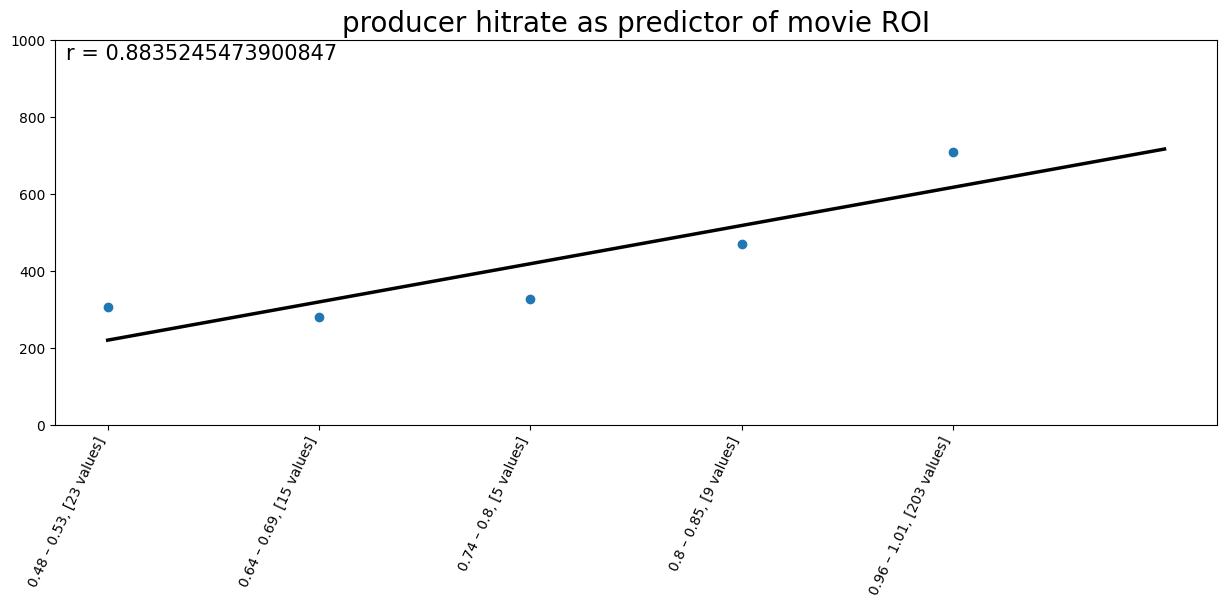

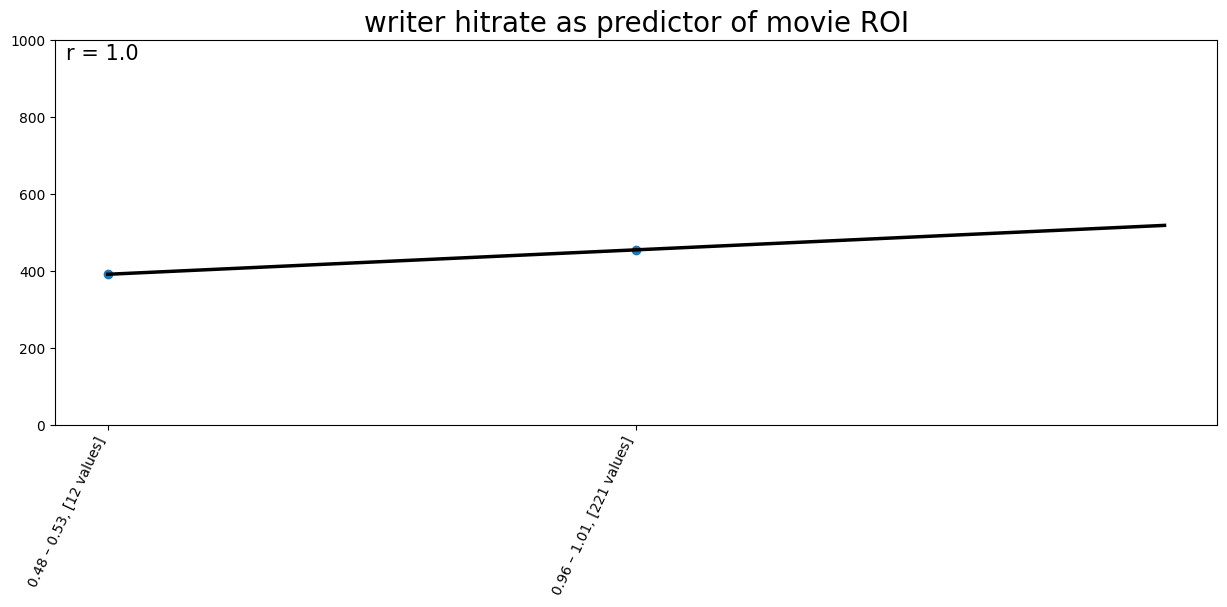

In [33]:
for profession in professions:
    plot(
        "{} hitrate as predictor of movie ROI".format(profession),
        query(profession, 'positive_ROI', 'ROI')[0],
        query(profession, 'positive_ROI', 'ROI')[1],
    )

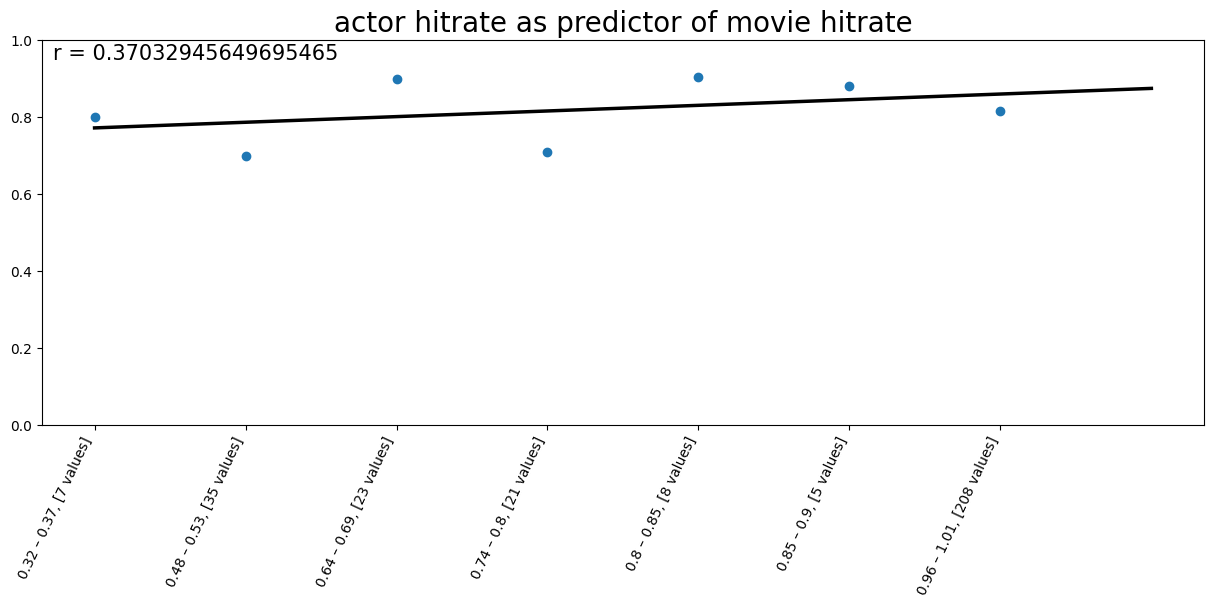

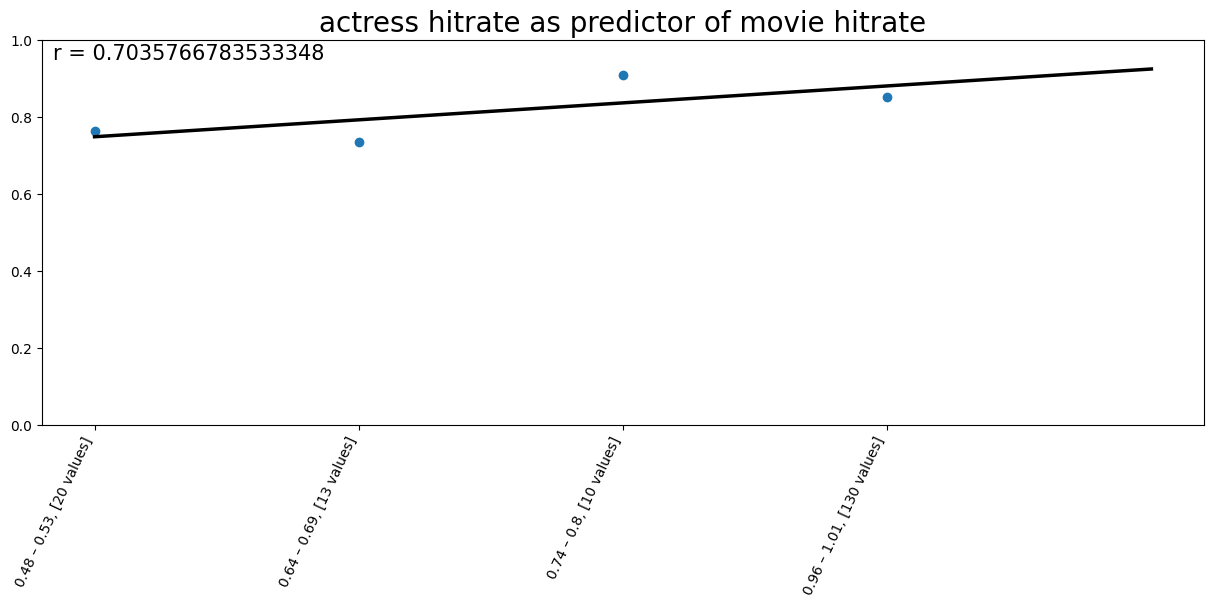

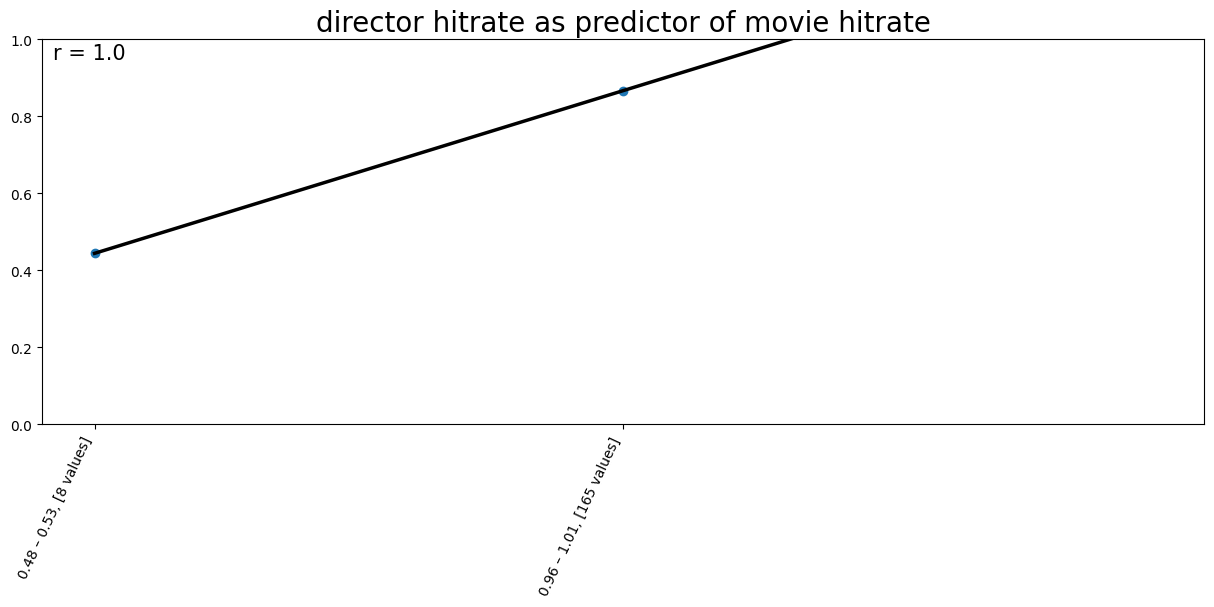

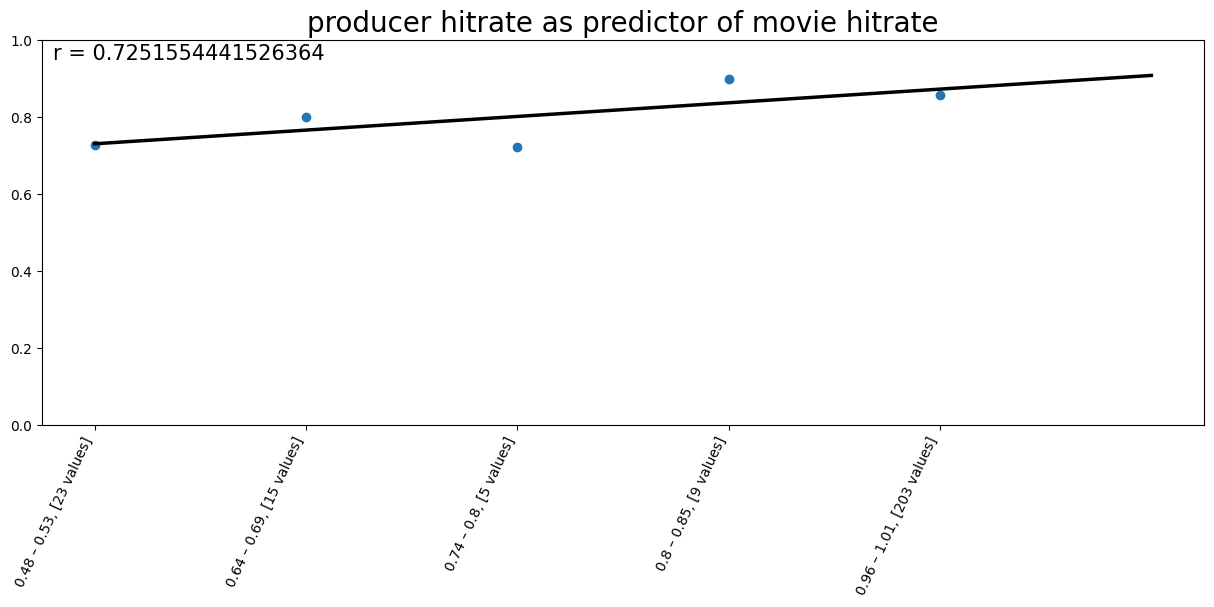

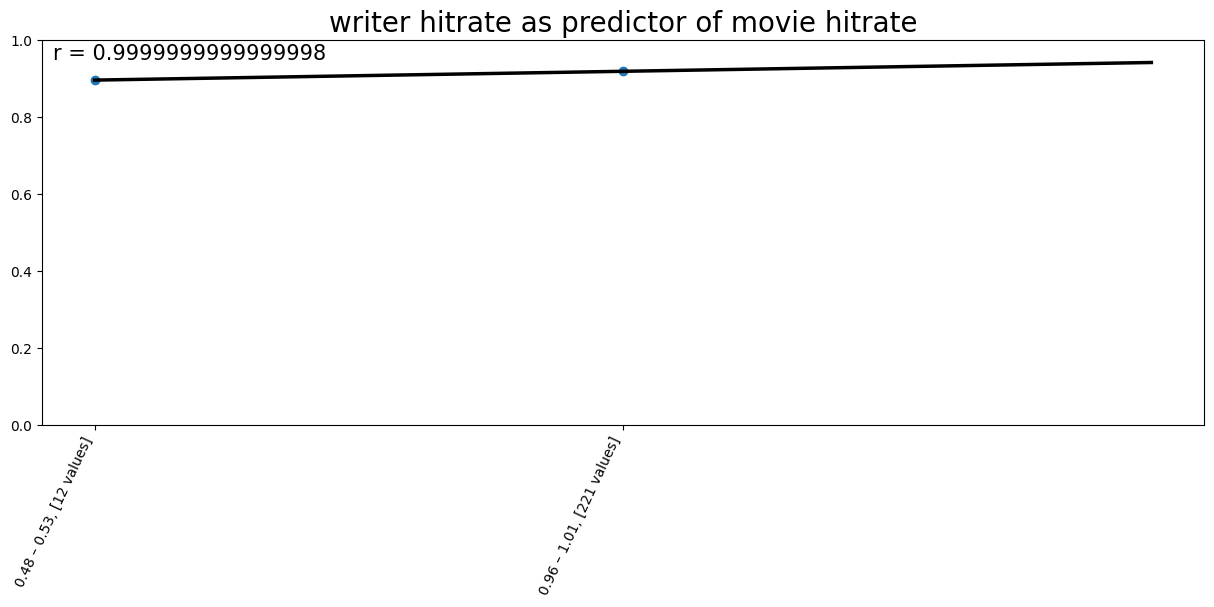

In [34]:
for profession in professions:
    plot(
        "{} hitrate as predictor of movie hitrate".format(profession),
        query(profession, 'positive_ROI', 'positive_ROI')[0],
        query(profession, 'positive_ROI', 'positive_ROI')[1],
    )

In [35]:
query('actor', 'positive_ROI', 'positive_ROI')

(['0.32 – 0.37, [7 values]',
  '0.48 – 0.53, [35 values]',
  '0.64 – 0.69, [23 values]',
  '0.74 – 0.8, [21 values]',
  '0.8 – 0.85, [8 values]',
  '0.85 – 0.9, [5 values]',
  '0.96 – 1.01, [208 values]'],
 [0.8,
  0.6984126984126984,
  0.8974358974358975,
  0.7088607594936709,
  0.9032258064516129,
  0.88,
  0.8138528138528138],
 0.37032945649695465)

In [36]:
years

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

In [37]:
professions

['actor', 'actress', 'director', 'producer', 'writer']

In [99]:
columns=[]

for profession in professions:
    for a in attributes:
        for b in attributes:
            columns.append([profession, a, b])

In [100]:
corr_dict = {}

for year in years[1:-1]:
    
    corr_dict[year]=[]
    
    try:
        dataset1 = cast[cast.year <= year].copy()
        dataset2 = cast[cast.year > year].copy()
        intersection = set(dataset1.person_id.unique()).intersection(set(dataset2.person_id.unique()))
        dataset1 = dataset1[dataset1.person_id.isin(intersection)]
        dataset2 = dataset2[dataset2.person_id.isin(intersection)]

        for profession in professions:
            for a in attributes:
                for b in attributes:
                    correlation = query(profession, a, b)
                    corr_dict[year].append(correlation[2])
    except:
        continue

# You are going to encounter some errors of the like: "divide by zero encountered in divide."

# This means that a couple correlations will end up as zero in the final matrix,
# but the majority of them will not be. I am not worrying about it.

/Users/angeloturri/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/angeloturri/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/angeloturri/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/angeloturri/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/angeloturri/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/angeloturri/opt/anaco

In [101]:
corr_dict['profession']=[i[0] for i in columns]
corr_dict['profession attribute'] = [i[1] for i in columns]
corr_dict['movie attribute'] = [i[2] for i in columns]

In [102]:
corrs = pd.DataFrame(corr_dict, index=[", ".join(i) for i in columns])
corrs

,2011,2012,2013,2014,2015,2016,2017,profession,profession attribute,movie attribute
"actor, ROI, ROI",0.517618,0.297078,-0.108282,-0.047174,0.042940,-0.582521,-0.244290,actor,ROI,ROI
"actor, ROI, positive_ROI",0.650185,0.343615,0.850382,0.733300,0.684684,0.697354,0.556941,actor,ROI,positive_ROI
"actor, positive_ROI, ROI",-0.562531,-0.206450,0.472287,0.757975,-0.104805,0.245832,0.170569,actor,positive_ROI,ROI
"actor, positive_ROI, positive_ROI",0.833536,0.312845,0.370329,0.739181,0.592213,0.768892,0.753113,actor,positive_ROI,positive_ROI
"actress, ROI, ROI",0.139770,0.013054,0.173073,-0.282762,-0.613133,-0.346600,-0.530846,actress,ROI,ROI
"actress, ROI, positive_ROI",0.357667,0.482744,0.550390,0.413077,0.092577,-0.075086,0.797211,actress,ROI,positive_ROI
"actress, positive_ROI, ROI",-0.347748,-0.061972,0.103882,-0.301194,-0.620696,-0.669187,0.251169,actress,positive_ROI,ROI
"actress, positive_ROI, positive_ROI",0.518840,0.469152,0.703577,0.547337,0.293471,0.357753,0.453921,actress,positive_ROI,positive_ROI
"director, ROI, ROI",0.214926,0.529500,-0.053224,-0.243932,-0.379991,-0.308961,-0.066993,director,ROI,ROI
"director, ROI, positive_ROI",0.878561,0.849295,0.422216,0.272006,0.481013,0.333237,0.227901,director,ROI,positive_ROI


In [103]:
average_correlation_years = corrs.groupby('profession').mean(numeric_only = True)

In [104]:
average_correlation_years

,2011,2012,2013,2014,2015,2016,2017
profession,,,,,,,
actor,0.359702,0.186772,0.396179,0.545821,0.303758,0.282389,0.309083
actress,0.167132,0.225745,0.382730,0.094114,-0.211945,-0.183280,0.242864
director,0.773372,0.844699,0.592248,0.507018,0.525255,0.012138,0.080454
producer,0.133125,0.557947,0.699587,0.676800,0.577005,0.343635,0.643712
writer,0.809051,0.848506,0.863901,0.579768,0.792487,0.011639,0.547786


In [105]:
average_correlation_years['average predictive power'] = \
sum(average_correlation_years[col] for col in average_correlation_years.columns)/\
len(average_correlation_years.columns)

In [106]:
average_correlation_years.iloc[:, -1:]

,average predictive power
profession,
actor,0.340529
actress,0.102480
director,0.476455
producer,0.518830
writer,0.636162
